In [1]:
import datetime
import logging
import os
import matplotlib.pyplot as plt
import pandas as pd
from ocean_navigation_simulator.problem_factories.Constructor import (
    Constructor,
)
from ocean_navigation_simulator.problem_factories.SeaweedMissionGenerator import SeaweedMissionGenerator

from ocean_navigation_simulator.utils.misc import set_arena_loggers
# These lines in VSCode to avoid reloading the kernel when changes are made to the external kernel
%load_ext autoreload
%autoreload 2

# Settings for where the problem csv is saved
my_path = os.getcwd()
results_folder = os.path.join(my_path, "tmp/missions/")
os.makedirs(results_folder, exist_ok=True)

## Generate Random Missions

### 1. Arena Configuration and Mission configuration

In [4]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400000.0,
        "u_max_in_mps": 0.2,
        "motor_efficiency": 1.0,
        "solar_panel_size": 100,
        "solar_efficiency": 1,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "keep_newest_days": 365,
        "region": "Region 3",
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "/Users/matthiaskiller/Desktop/data/tmp/hindcast/",
                "source": "HYCOM",
                "type": "hindcast",
            },
        },
        "forecast": None,
        # {
        #     "field": "OceanCurrents",
        #     "source": "longterm_average",
        #     "source_settings": {
        #         "forecast": {
        #             "field": "OceanCurrents",
        #             "source": "forecast_files",
        #             "source_settings": {
        #                 "folder": "/Users/matthiaskiller/Desktop/data/tmp/forecast/",
        #                 "source": "Copernicus",
        #                 "type": "forecast",
        #             },
        #         },
        #         "average": {
        #             "field": "OceanCurrents",
        #             "source": "hindcast_files",
        #             "source_settings": {
        #                 "folder": "/Users/matthiaskiller/Desktop/data/Copernicus/Averages_monthly/",
        #                 "currents": "normal",
        #             },
        #         },
        #     },
        # },
    },
    "solar_dict": {
        "hindcast": { 
            "field": 'SolarIrradiance',
            "source": 'analytical_wo_caching', # can also be analytical_w_caching
            "source_settings": {
                "boundary_buffer": [0.2, 0.2],
                "x_domain": [-180, 180],
                "y_domain": [-90, 90],
                "temporal_domain": 
                ['2020-01-01T00:00:00+00:00','2023-01-10T00:00:00+00:00'
                    # datetime.datetime(year=2020, month=1, day=1, tzinfo=datetime.timezone.utc),
                    # datetime.datetime(year=2023, month=1, day=10, tzinfo=datetime.timezone.utc),
                ],
                "spatial_resolution": 0.1,
                "temporal_resolution": 3600,
            },
        },
        "forecast": None,
    },
    "seaweed_dict": {
        "hindcast": {
            "field": 'SeaweedGrowth',
            "source": 'GEOMAR',
            "source_settings": {
                "filepath": './ocean_navigation_simulator/package_data/nutrients/', #'./data/nutrients/2022_monthly_nutrients_and_temp.nc' 
            },
        },
        "forecast": None,
    },
    "timeout": 3600 * 24 * 30, 
}

# change to this if basic setup works
set_arena_loggers(logging.INFO)
logging.getLogger("SeaweedMissionGenerator").setLevel(logging.INFO)

config = {
    "scenario_config": arena_config,
    "x_range": [-120, -70],
    "y_range": [-20, 20],
    "t_range":
    ["2022-06-01T00:00:00+00:00", "2022-07-10T00:00:00+00:00"
        #datetime.datetime(year=2022, month=7, day=19, tzinfo=datetime.timezone.utc),
        #datetime.datetime(year=2022, month=8, day=20, tzinfo=datetime.timezone.utc),
    ],
    "time_horizon": 2592000, # 3600 * 24 * 15 # in seconds
    "n_samples": 2, # number of start samples per runner
    "min_distance_from_land": 0.5, # degree
    ##### HJ Planner #####
    "hj_specific_settings": {
        "replan_on_new_fmrc": True,
        "replan_every_X_seconds": False,
        "direction": "backward",
        "n_time_vector": 24*30,
        # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
        "deg_around_xt_xT_box_global": 10,  # area over which to run HJ_reachability on the first global run
        "deg_around_xt_xT_box": 1.1,  # area over which to run HJ_reachability
        "accuracy": "high",
        "artificial_dissipation_scheme": "local_local",
        "T_goal_in_seconds": 3600 * 24 * 30,
        "use_geographic_coordinate_system": True,
        "progress_bar": True,
        "grid_res": 0.0833,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "grid_res_global": 0.166,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
        "d_max": 0.0,
        "calc_opt_traj_after_planning": False
    },
}



### 2. Run generation

In [5]:
nb_workers = 1
all_problems = []
for worker in range(nb_workers):
    mission_generator = SeaweedMissionGenerator(
        config=config
        | {
            "seed": 2023422 + worker,
            "cache_folder": results_folder + str(worker) + "_",
        }
    )
    problems = mission_generator.generate_batch()
    all_problems.extend(problems)
df = pd.DataFrame([problem.to_dict() for problem in all_problems])
df.to_csv(results_folder + "problems.csv")

Starting to connect to c3


 59%|█████▊    | 24/41 [00:10<00:07,  2.37it/s]


KeyboardInterrupt: 

### 3. Visualize generated Navigation Problems

In [13]:
# visualize starts (which defines a c3 "mission") 
SeaweedMissionGenerator.plot_starts(
    problems=all_problems, config=config
)

IndexError: single positional indexer is out-of-bounds

### 4. To c3 mission

In [7]:
exp = []
for idx, problem in enumerate(all_problems):
    try:
        exp.append(problem.to_c3_mission_config())
    except BaseException:
        continue

In [8]:
print(len(exp))

2


# OceanSimRun

In [52]:
NoObserver = {"observer": None}

# Controller Configs
SeaweedCtrlConfig = {
    "replan_on_new_fmrc": True,
    "replan_every_X_seconds": False,
    "direction": "backward",
    "n_time_vector": 24*30,
    # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
    "deg_around_xt_xT_box_global": 10,  # area over which to run HJ_reachability on the first global run
    "deg_around_xt_xT_box": 1.4,  # area over which to run HJ_reachability
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "T_goal_in_seconds": 3600 * 24 * 30,
    "use_geographic_coordinate_system": True,
    "progress_bar": True,
    "grid_res": 0.083,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
    "grid_res_global": 0.166, # for first global planning Note: this is in deg lat, lon 
    "d_max": 0.0,
    "calc_opt_traj_after_planning": False,
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJBSeaweed2DPlanner.HJBSeaweed2DPlanner"
}


objective_conf = {"type": "max_seaweed"}

In [53]:
idx_mission  = 1
mission_config = exp[idx_mission]
mission_config


{'x_0': [{'lon': -84.55056474001879,
   'lat': 6.959637148907362,
   'date_time': '2022-07-03T04:31:27.058206+00:00'}],
 'seed': 2023422}

In [54]:
import ocean_navigation_simulator
filepath = ocean_navigation_simulator.__file__
module_path = os.path.dirname(filepath)
nutrient_path = module_path + "/package_data/nutrients/"
averages_path = module_path + "/package_data/monthly_averages/"


arena_config["seaweed_dict"]["hindcast"]["source_settings"][
    "filepath"
] = nutrient_path

#arena_config["timeout"] = this.mission.experiment.timeout_in_sec
to_download_forecast_files = False

# for hindcast
# arena_config["ocean_dict"]["hindcast"]["source_settings"]["folder"] = (
#     "/tmp/hindcast_files/" + this.id + "/"
# )
# for forecast
# if arena_config["ocean_dict"]["forecast"] is not None:
#     arena_config["ocean_dict"]["forecast"]["source_settings"]["folder"] = (
#         "/tmp/forecast_files/" + this.id + "/"
#     )
#     to_download_forecast_files = (
#         arenaConfig["ocean_dict"]["forecast"]["source"] == "forecast_files"
#     )

# for hindcast
arena_config["ocean_dict"]["hindcast"]["source_settings"]["folder"] = (
    "/tmp/" + "abc"+ "/hindcast_files/"
)
# for forecast
if arena_config["ocean_dict"]["forecast"] is not None:
    if arena_config["ocean_dict"]["forecast"]["source"] == "longterm_average":
        arena_config["ocean_dict"]["forecast"]["source_settings"]["average"]["source_settings"]["folder"] = averages_path
        arena_config["ocean_dict"]["forecast"]["source_settings"]["forecast"][
            "source_settings"
        ]["folder"] = ("/tmp/" + "abc" + "/forecast_files/")
        to_download_forecast_files = (
            arena_config["ocean_dict"]["forecast"]["source_settings"]["forecast"][
                "source"
            ]
            == "forecast_files"
        )
    else:
        arena_config["ocean_dict"]["forecast"]["source_settings"]["folder"] = (
            "/tmp/" + "abc" + "/forecast_files/"
        )
        to_download_forecast_files = (
            arena_config["ocean_dict"]["forecast"]["source"] == "forecast_files"
        )


In [55]:
from ocean_navigation_simulator.environment.PlatformState import SpatioTemporalPoint

# prepping the file download
point_to_check = SpatioTemporalPoint.from_dict(mission_config["x_0"][0])
t_interval = [
    point_to_check.date_time,
    point_to_check.date_time
    + datetime.timedelta(
        seconds=arena_config["timeout"]
        + arena_config["casadi_cache_dict"]["time_around_x_t"]
        + 7200
    ),
]

In [56]:
from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory

import contextlib

@contextlib.contextmanager
def dummy_context_mgr():
    yield None

with (
    ArenaFactory.download_files(
        config=arena_config,
        type="hindcast",
        t_interval=t_interval,
        points=[point_to_check.to_spatial_point()],
    ) as download_hindcast_files_to_local,
    ArenaFactory.download_files(
        config=arena_config,
        type="forecast",
        t_interval=t_interval,
        points=[point_to_check.to_spatial_point()], 
        keep_newest_days=arena_config["ocean_dict"]["keep_newest_days"]
    )
    if to_download_forecast_files
    else dummy_context_mgr() as download_forecast_files_to_local,
):
    try:
        # Step 0: Create Constructor object which contains arena, problem, controller and observer
        constructor = Constructor(
            arena_conf=arena_config,
            mission_conf=mission_config,
            objective_conf=objective_conf,
            ctrl_conf=SeaweedCtrlConfig,
            observer_conf=NoObserver,
        )

        # Step 1.1 Retrieve problem
        problem = constructor.problem

        # Step 1.2: Retrieve arena
        arena = constructor.arena
        observation = arena.reset(platform_state=problem.start_state)
        problem_status = arena.problem_status(problem=problem)

        # Step 2: Retrieve Controller
        controller = constructor.controller

        # Step 3: Retrieve observer
        observer = constructor.observer
        observer.observe(observation)
        observation.forecast_data_source = observer

        # Step 4: Run Arena
        while problem_status == 0:
            # Get action
            action = controller.get_action(observation=observation)

            # execute action
            observation = arena.step(action)

            # Observer data assimilation
            observer.observe(observation)
            observation.forecast_data_source = observer

            # update problem status
            problem_status = arena.problem_status(problem=problem)

        # new_osr.status = "finished_running"
        # new_osr.terminationReason = arena.problem_status_text(problem_status)
        # if arena.problem_status_text(problem_status) == "Success":
        #     new_osr.T_arrival_time = (
        #         arena.state_trajectory[-1, 2] - arena.state_trajectory[0, 2]
        #     ) / 3600
        # logged_error_message = None

    except Exception as e:
        # if we crash we should upload that to the table for debugging
        print("Error Message: ", e)
        #new_osr.terminationReason = "run_failed"
        #new_osr.status = "run_failed"
        #logged_error_message = e
        # raise e         

INFO:arena.factory:Downloading 36 files to '/tmp/abc/hindcast_files/'.
100%|██████████| 36/36 [01:08<00:00,  1.91s/it]
INFO:arena.ocean_field:DataField: Create Hindcast Source (0.6s)
INFO:arena.ocean_field:DataField: Forecast is the same as Hindcast for OceanCurrents.
INFO:arena.solar_field:DataField: Create Hindcast Source (0.0s)
INFO:arena.solar_field:DataField: Forecast is the same as Hindcast for SolarIrradiance.
INFO:arena.seaweed_growth_field:DataField: Create Hindcast Source (12.3s)
INFO:arena.seaweed_growth_field:DataField: Forecast is the same as Hindcast for SeaweedGrowth.
INFO:arena:Arena: Generate Sources (12.9s)
INFO:arena:Arena: Generate Platform (0.0s)
INFO:arena.factory:ArenaFactory: Creating Arena for None (12.92s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (13.2s)
INFO:arena.controller:HJPlannerBase: Planning because of new forecast (Old: None, New: 0)
INFO:arena.seaweed_field.seaweed_grow

In [57]:
# Step 4: create the OceanSimResult object with the files and upload it
if arena is not None:
    # Create a large dict with all trajectory data
    trajs_dict = {
        "sim_traj": arena.state_trajectory,
        "sim_ctrl": arena.action_trajectory,
    }
    if controller is not None:
        if len(controller.planned_trajs) > 0:
            trajs_dict["plans"] = controller.planned_trajs

 

In [58]:
df = arena.get_plot_data_for_wandb()

In [59]:
df

,timesteps,dates_timestamp,dates_string,lon,lat,battery_charge,seaweed_mass,inside_garbage
0,0,2022-07-03 04:31:27.058206+00:00,22-07-03 04:31,-84.550565,6.959637,1.000000e+02,100.000000,0.0
1,1,2022-07-03 04:41:27.058206+00:00,22-07-03 04:41,-84.550759,6.959258,0.000000e+00,99.984336,0.0
2,2,2022-07-03 04:51:27.058206+00:00,22-07-03 04:51,-84.550271,6.958050,0.000000e+00,99.968674,0.0
3,3,2022-07-03 05:01:27.058206+00:00,22-07-03 05:01,-84.549791,6.956842,0.000000e+00,99.953015,0.0
4,4,2022-07-03 05:11:27.058206+00:00,22-07-03 05:11,-84.549320,6.955636,0.000000e+00,99.937359,0.0
...,...,...,...,...,...,...,...,...
2433,2433,2022-07-20 02:01:27.058206+00:00,22-07-20 02:01,-83.571879,8.497442,1.439948e+09,68.783482,0.0
2434,2434,2022-07-20 02:11:27.058206+00:00,22-07-20 02:11,-83.571069,8.498186,1.439945e+09,68.780246,0.0
2435,2435,2022-07-20 02:21:27.058206+00:00,22-07-20 02:21,-83.570256,8.498927,1.439942e+09,68.777068,0.0
2436,2436,2022-07-20 02:31:27.058206+00:00,22-07-20 02:31,-83.569442,8.499666,1.439938e+09,68.773949,0.0


#### Plot the problem on the map


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=problem.start_state.to_spatio_temporal_point(), x_T=problem.start_state.to_spatio_temporal_point(),
    deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)

ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)
ax = problem.plot(ax=ax)
fig = ax.get_figure()

fig = plt.figure(fig)

#TODO: log .svg to c3
plt.savefig("current_with_start.svg")
plt.savefig("current_with_start.jpg", dpi=80)

wandb.save("current_with_start.svg")

image = wandb.Image("current_with_start.jpg", caption="Current with start")
wandb.log({"Current with start": image})

In [ ]:
lat_bnds = [-20,20]
lon_bnds = [-120,-70]


ax = arena.seaweed_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)

ax = problem.plot(ax=ax)
fig = ax.get_figure()

fig = plt.figure(fig)

plt.savefig("seaweed_with_start.svg")
plt.savefig("seaweed_with_start.jpg", dpi=80)

wandb.save("seaweed_with_start.svg")

image = wandb.Image("seaweed_with_start.jpg", caption="Seaweed with start")
wandb.log({"Seaweed with start": image})

### 4. Get metrics

In [ ]:
print(arena.platform.state.seaweed_mass.kg)
fig, ax = plt.subplots()
ax = arena.plot_seaweed_trajectory_on_timeaxis(ax=ax)
fig = ax.get_figure()

fig = plt.figure(fig)

plt.savefig("seaweed_trajectory_on_timeaxis.svg")
plt.savefig("seaweed_trajectory_on_timeaxis.jpg", dpi=80)

wandb.save("seaweed_trajectory_on_timeaxis.svg")

image = wandb.Image("seaweed_trajectory_on_timeaxis.jpg", caption="Seaweed trajectory on timeaxis")
wandb.log({"Seaweed trajectory on timeaxis": image})


ax = arena.plot_all_on_map(problem=problem, background="seaweed",return_ax=True)
fig = ax.get_figure()
fig = plt.figure(fig)

plt.savefig("seaweed_trajectory_on_map.svg")
plt.savefig("seaweed_trajectory_on_map.jpg", dpi=80)

wandb.save("seaweed_trajectory_on_map.svg")

image = wandb.Image("seaweed_trajectory_on_map.jpg", caption="Seaweed trajectory on map")
wandb.log({"Seaweed trajectory on map": image})



ax = arena.plot_all_on_map(problem=problem, background="current",return_ax=True)
fig = ax.get_figure()
fig = plt.figure(fig)

plt.savefig("current_trajectory_on_map.svg")
plt.savefig("current_trajectory_on_map.jpg", dpi=80)

wandb.save("current_trajectory_on_map.svg")

image = wandb.Image("current_trajectory_on_map.jpg", caption="Current trajectory on map")
wandb.log({"Current trajectory on map": image})




metrics_folder = f"{results_folder}metrics"

# arena.animate_trajectory(
#     margin=0.25,
#     problem=problem,
#     temporal_resolution=14400,
#     background="current",
#     output=f"{metrics_folder}/platform_trajectories_currents_{idx_mission}.mp4",
#     fps=6,
# )

# arena.animate_trajectory(
#     margin=0.25,
#     problem=problem,
#     temporal_resolution=14400,
#     background="seaweed",
#     output=f"{metrics_folder}/platform_trajectories_seaweed_{idx_mission}.mp4",
#     fps=6,
# )

In [ ]:
controller.animate_value_func_3D()

## 5. Wandb

In [25]:
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=14400,
    background="current",
    output=f"{temp_folder}platform_trajectories_currents_{idx_mission}.gif",
    fps=6,
)
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=14400,
    background="seaweed",
    output=f"{temp_folder}platform_trajectories_seaweed_{idx_mission}.gif",
    fps=6,
)

INFO:arena.seaweed_field.seaweed_growth_source:AnalyticalSource: get Data over Area finished (3.4s)


In [26]:
import wandb
wandb.finish()

In [27]:
import wandb
### Prepare data for WandB
ctrlConfig = SeaweedCtrlConfig
missionConfig = config
observerConfig = NoObserver

# Prepare variables for run naming

# Planning horizon in days
T_in_days = SeaweedCtrlConfig["T_goal_in_seconds"] / (24 * 3600)

# Prepare string whether we use only HC or FC/HC
if arena_config["ocean_dict"]["forecast"] is not None:
    data_sources = "FC_HC"
else:
    data_sources = "HC"

if (
    ctrlConfig["ctrl_name"]
    == "ocean_navigation_simulator.controllers.hj_planners.HJBSeaweed2DPlanner.HJBSeaweed2DPlanner"
):
    ctrl_name = "HJ"
else:
    ctrl_name = "undefined"

deg_around_xt_xT_box_global = ctrlConfig["deg_around_xt_xT_box_global"]
deg_around_xt_xT_box = ctrlConfig["deg_around_xt_xT_box"]
grid_res_global = ctrlConfig["grid_res_global"]
grid_res = ctrlConfig["grid_res"]

# Log metrics in WandB

os.environ["WANDB_API_KEY"] = "4c142c345dfc64f3c73aa1b2834989c7eb91efbe"

wandb.init(
    reinit=True,
    # Set the project where this run will be logged
    project="Long Horizon Seaweed Maximization",
    entity="ocean-platform-control",
    id="test_wandb_locally",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"{ctrl_name}_{data_sources}_days_{T_in_days}_deg_{deg_around_xt_xT_box_global}_{deg_around_xt_xT_box}_res_{grid_res_global}_{grid_res}id_{234234}_",
    # Track hyperparameters and run metadata
    config={
        "missionConfig": missionConfig,
        "arenaConfig": arena_config,
        "ctrlConfig": ctrlConfig,
        "observerConfig": observerConfig
        # "path_to_local_data": user_param["metrics_dir"],
    },
)
wandb.log({"data_to_plot": wandb.Table(dataframe=arena.get_plot_data_for_wandb())},commit=False)


wandb: Currently logged in as: matthiaskiller (ocean-platform-control). Use `wandb login --relogin` to force relogin


INFO:arena.seaweed_field.seaweed_growth_source:AnalyticalSource: get Data over Area finished (0.2s)
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
INFO:arena.seaweed_field.seaweed_growth_source:AnalyticalSource: get Data over Area finished (3.5s)


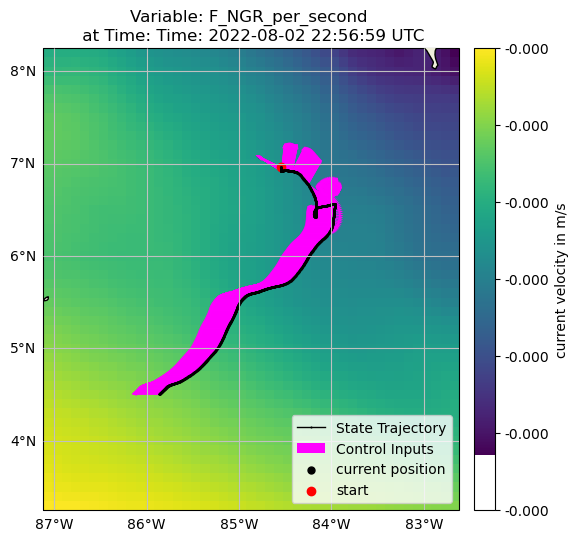

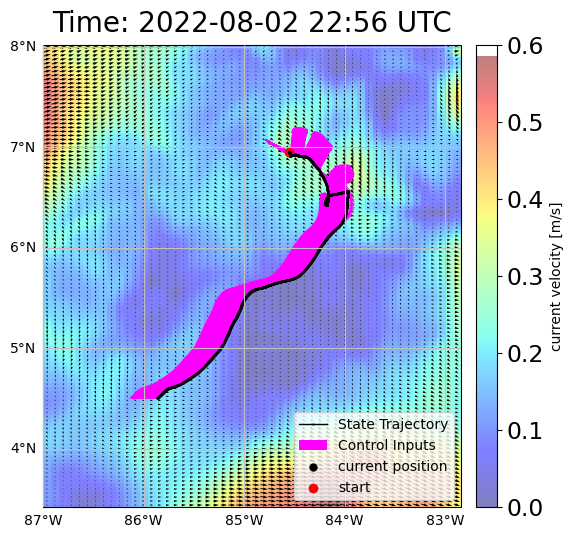

In [28]:
# t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
#     x_0=problem.start_state.to_spatio_temporal_point(), x_T=problem.start_state.to_spatio_temporal_point(),
#     deg_around_x0_xT_box=1, temp_horizon_in_s=3600
# )

# ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
#     time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
# )
# ax = problem.plot(ax=ax)
# fig = ax.get_figure()

# fig = plt.figure(fig)

# #TODO: log .svg to c3
# plt.savefig("current_with_start.svg")
# plt.savefig("current_with_start.jpg", dpi=80)

# wandb.save("current_with_start.svg")

# image = wandb.Image("current_with_start.jpg", caption="Current with start")
# wandb.log({"Current with start": image})


# lat_bnds = [-20,20]
# lon_bnds = [-120,-70]


# ax = arena.seaweed_field.hindcast_data_source.plot_data_at_time_over_area(
#     time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
# )

# ax = problem.plot(ax=ax)
# fig = ax.get_figure()

# fig = plt.figure(fig)

# plt.savefig("seaweed_with_start.svg")
# plt.savefig("seaweed_with_start.jpg", dpi=80)

# wandb.save("seaweed_with_start.svg")

# image = wandb.Image("seaweed_with_start.jpg", caption="Seaweed with start")
# wandb.log({"Seaweed with start": image})


# print(arena.platform.state.seaweed_mass.kg)
# fig, ax = plt.subplots()
# ax = arena.plot_seaweed_trajectory_on_timeaxis(ax=ax)
# fig = ax.get_figure()

# fig = plt.figure(fig)

# plt.savefig("seaweed_trajectory_on_timeaxis.svg")
# plt.savefig("seaweed_trajectory_on_timeaxis.jpg", dpi=80)

# wandb.save("seaweed_trajectory_on_timeaxis.svg")

# image = wandb.Image("seaweed_trajectory_on_timeaxis.jpg", caption="Seaweed trajectory on timeaxis")
# wandb.log({"Seaweed trajectory on timeaxis": image})
temp_folder = "/tmp/" + "123444" + "/"


ax = arena.plot_all_on_map(problem=problem, background="seaweed",return_ax=True)
fig = ax.get_figure()
fig = plt.figure(fig)

plt.savefig(temp_folder + "seaweed_trajectory_on_map.svg")
plt.savefig(temp_folder + "seaweed_trajectory_on_map.jpg", dpi=80)

wandb.save(temp_folder + "seaweed_trajectory_on_map.svg")

image = wandb.Image(temp_folder + "seaweed_trajectory_on_map.jpg", caption="Seaweed trajectory on map")
wandb.log({"Seaweed trajectory on map": image},commit=False)



ax = arena.plot_all_on_map(problem=problem, background="current",return_ax=True)
fig = ax.get_figure()
fig = plt.figure(fig)

plt.savefig(temp_folder + "current_trajectory_on_map.svg")
plt.savefig(temp_folder + "current_trajectory_on_map.jpg", dpi=80)

wandb.save(temp_folder + "current_trajectory_on_map.svg")

image = wandb.Image(temp_folder + "current_trajectory_on_map.jpg", caption="Current trajectory on map")
wandb.log({"Current trajectory on map": image},commit=False)




#metrics_folder = f"{results_folder}metrics"

arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=14400,
    background="current",
    output=f"{temp_folder}platform_trajectories_currents_{idx_mission}.gif",
    fps=6,
)
arena.animate_trajectory(
    margin=0.25,
    problem=problem,
    temporal_resolution=14400,
    background="seaweed",
    output=f"{temp_folder}platform_trajectories_seaweed_{idx_mission}.gif",
    fps=6,
)
wandb.log({"video": wandb.Video(f"{temp_folder}platform_trajectories_currents_{idx_mission}.gif", fps=6, format="gif")},commit=False)
wandb.log({"video": wandb.Video(f"{temp_folder}platform_trajectories_seaweed_{idx_mission}.gif", fps=6, format="gif")},commit=True)

In [31]:
import numpy as np
wandb.summary["value_fct"]=np.array(constructor.controller.all_values)
wandb.summary["reach_times"]=np.array(constructor.controller.reach_times)

wandb: WARNING Serializing object of type ndarray that is 848304 bytes


In [45]:
wandb.finish()